Everything below follows from the [EconML User Guide](https://econml.azurewebsites.net/spec/api.html).

# Prelude: Why Heterogeneous Treatment Effects?
What are the typical use cases of estimating heterogeneous treatment effects?
1. Customer targeting -- we want to _personalize_ our interventions (e.g. determine whom to send pushes to).
2. Personalized pricing -- we want to estimate personalized price elasticities, and set prices differently for different users.
3. Learning Click-Through-Rates (CTRs). This is _not_ a substitute for running multiple A/B tests, but rather a complementary analysis.

# Problem Setup and API Design
We want to estimate the conditional average treatment effect (CATE). In the discrete case:

$$ \tau(t_0, t_1, x) = E[Y(t_1) - Y(t_0)|X = x] $$

And in the case of a continuous treatment, like price:

$$ \partial \tau (t, x) = E[\nabla_t Y(t) | X = x] $$

For Econ ML, we'll assume we have data of the form

$$ {Y_i(T_i), T_i, X_i, W_i, Z_i} $$

where
* $ Y_i(T_i) $ is the observed outcome;
* $ T_i $ is the treatment;
* $ X_i $ are the covariates used for heterogeneity;
* $ W_i $ are other observable covariates used as controls;
* $ Z_i $ are instruments that affect the treatment, but don't affect the outcome except through the treatment.

## API
Each `Estimator` class will have the following main methods:
* `fit`; which estimates the counterfactual model from data;
* `effect`; which estimates the discrete heterogeneous treatment effect between two treatment points;
* `marginal_effect`; which estimates the continuous heterogeneous marginal effect around a base treatment point;
* `effect_interval` & `marginal_effect_interval`; which compute confidence intervals when explicitly called for.

# Example API Use on Toy Data (Not Working)

In [14]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Generate Data

In [1]:
import numpy as np

# Instance parameters
n_controls = 100
n_instruments = 1
n_features = 1 
n_treatments = 1
alpha = np.random.normal(size=(n_controls, 1))
beta = np.random.normal(size=(n_instruments, 1))
gamma = np.random.normal(size=(n_treatments, 1))
delta = np.random.normal(size=(n_treatments, 1))
zeta = np.random.normal(size=(n_controls, 1))

n_samples = 1000
W = np.random.normal(size=(n_samples, n_controls))
Z = np.random.normal(size=(n_samples, n_instruments))
X = np.random.normal(size=(n_samples, n_features))
eta = np.random.normal(size=(n_samples, n_treatments))
epsilon = np.random.normal(size=(n_samples, 1))
T = np.dot(W, alpha) + np.dot(Z, beta) + eta
y = np.dot(T**2, gamma) + np.dot(np.multiply(T, X), delta) + np.dot(W, zeta) + epsilon

## Fit Basic Causal Model

In [15]:
from econml._cate_estimator import BaseCateEstimator
from econml.orf import DMLOrthoForest

In [18]:
cfest = DMLOrthoForest()
# cfest.fit(y, T, X=X, W=W, inference='bootstrap')

NOTE! The above doesn't work. Need to go through specific examples with orthogonal CATE estimators (tomorrow).

# Forest Based Estimators
Based on [EconML User Guide: Forest Based Estimators](https://econml.azurewebsites.net/spec/estimation/forest.html#orthoforestuserguide). EconML provides three forest-based estimation methods:
* Orthogonal Random Forest Estimator
* Forest Double Machine Learning Estimator (estimating an ML model for the outcome and an ML model for the treatment)
* Forest Doubly Robust Estimator

Recall that the main point of these methods is to estimate very flexible non-linear models of the heterogeneous treatment effect. Running OLS is undesirable in this situation because you will have to estimate heterogeneity by introducing lots of interactions, which OLS doesn't handle well (even worse if you're estimating a logit), and even then, the interactions may be misspecified (e.g. if interaction is nonlinear).

Moving beyond this book definition: maybe I can think of specific instances in which nonlinear interactions will happen...

## Forest Learners Examples
See [Forest Learners Example Notebook](https://github.com/microsoft/EconML/blob/main/notebooks/ForestLearners%20Basic%20Example.ipynb).

In [2]:
import numpy as np
import scipy.special
np.random.seed(123)
n = 2000
p = 10
X = np.random.normal(size=(n, p))
true_propensity = lambda x: .4 + .2 * (x[:, 0] > 0)
true_effect = lambda x: (x[:, 0] * (x[:, 0] > 0))
true_conf = lambda x: x[:, 1] + np.clip(x[:, 2], - np.inf, 0)
T = np.random.binomial(1, true_propensity(X))
Y =  true_effect(X) * T + true_conf(X) + np.random.normal(size=(n,))

## First Stage Nuisance Models

In [4]:
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from econml.sklearn_extensions.linear_model import WeightedLasso

def first_stage_reg():
    return GridSearchCVList([Lasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                               {'max_depth': [3, None],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def first_stage_clf():
    return GridSearchCVList([LogisticRegression(),
                             RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{'C': [0.01, .1, 1, 10, 100]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def final_stage():
    return GridSearchCVList([WeightedLasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

In [5]:
model_y = clone(first_stage_reg().fit(X, Y).best_estimator_)
model_y

GradientBoostingRegressor(min_samples_leaf=30, n_estimators=50,
                          random_state=123)

In [6]:
model_t = clone(first_stage_clf().fit(X, T).best_estimator_)
model_t

RandomForestClassifier(max_depth=3, min_samples_leaf=10, random_state=123)

## DML Estimators

In [7]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

n_samples, n_features = X.shape
subsample_fr_ = (n_samples/2)**(1-1/(2*n_features+2))/(n_samples/2)
est = CausalForestDML(model_y=model_y,
                      model_t=model_t,
                      discrete_treatment=True,
                      cv=3,
                      n_estimators=4000,
                      random_state=123)
est.tune(Y, T, X=X).fit(Y, T, X=X, cache_values=True)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be r

In [8]:
from econml.dml import NonParamDML
est2 = NonParamDML(model_y=model_y,
                   model_t=model_t,
                   cv=3,
                   discrete_treatment=True,
                   model_final=final_stage())
est2.fit(Y, T, X=X)

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

In [9]:
X_test = np.zeros((100, p))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [10]:
pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [11]:
pred2 = est2.effect(X_test)

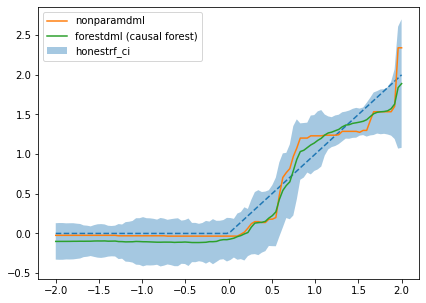

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), '--')
plt.plot(X_test[:, 0], pred2, label='nonparamdml')
plt.plot(X_test[:, 0], pred, label='forestdml (causal forest)')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4, label='honestrf_ci')
plt.legend()
plt.show()